In [14]:
import numpy as np
from scipy.stats import wasserstein_distance
from itertools import combinations

import matplotlib.pyplot as plt
import torch

In [15]:
import numpy as np
from scipy.stats import wasserstein_distance
from itertools import combinations

import matplotlib.pyplot as plt
import torch
from torch import nn

In [16]:
from sims import *

In [17]:
models = ["GCN","SAGE","GAT","CGCN"]
dataset_name='Amazon'
#dataset_name='Flickr'
#dataset_name='Cora'
#dataset_name='Pubmed'
#dataset_name='Citeseer'
path = 'model_data/'+dataset_name+'/'

In [18]:
import os

max_epochs={}
for model_name in models:
    files = os.listdir(path+model_name)
    for fv_path in files:
        #print(fv_path)
        fv_path, ext = fv_path.split(".")
        if ext != "npz":
            continue
        #print(fv_path)
        task,run_id,epoch = fv_path.split("_")
        epoch = int(epoch)
        #print(epoch)
        identifier = f"{model_name}/{task}_{run_id}_"
        
        # Update the maximum epoch for the current task and run_id combination
        if identifier not in max_epochs or epoch > max_epochs[identifier]:
            max_epochs[identifier] = epoch

In [19]:
max_epochs

{'GCN/NC_1_': 199,
 'GCN/NC_2_': 199,
 'GCN/LP_1_': 200,
 'GCN/LP_2_': 200,
 'GCN/LP_3_': 200,
 'SAGE/NC_1_': 100,
 'SAGE/NC_2_': 100,
 'SAGE/LP_1_': 200,
 'SAGE/LP_2_': 200,
 'GAT/NC_1_': 100,
 'GAT/NC_2_': 100,
 'GAT/LP_1_': 200,
 'GAT/LP_2_': 200,
 'CGCN/NC_1_': 100,
 'CGCN/NC_2_': 100,
 'CGCN/LP_1_': 200,
 'CGCN/LP_2_': 200}

In [26]:
run_ids = ["1","2"]
task = "NC"

models = ['SAGE']#,'SAGE','GAT','CGCN']

In [45]:
class NSALoss3(nn.Module):
    def __init__(self, mode='raw', **kwargs):
        super().__init__()
        self.mode = mode
    
    def forward(self, x, z):
        # normA1 = torch.max(torch.sqrt(torch.sum(x**2,axis=1)))
        # normA2 = torch.max(torch.sqrt(torch.sum(z**2,axis=1)))
        if self.mode=='raw':
            mean_x = torch.mean(x, dim=0)
            mean_z = torch.mean(z, dim=0)
            
            normA1 = torch.quantile(torch.sqrt(torch.sum((x - mean_x) ** 2, dim=1)),0.98)
            normA2 = torch.quantile(torch.sqrt(torch.sum((z - mean_z) ** 2, dim=1)),0.98)
            # normA1 = torch.quantile(torch.sqrt(torch.sum(x**2,axis=1)),0.98)
            # normA2 = torch.quantile(torch.sqrt(torch.sum(z**2,axis=1)),0.98)
            
            A1_pairwise = torch.flatten(torch.cdist(x,x))    # compute pairwise dist
            A2_pairwise = torch.flatten(torch.cdist(z,z))    # compute pairwise dist
            A1_pairwise = A1_pairwise/(2*normA1)
            A2_pairwise = A2_pairwise/(2*normA2)
        elif self.mode=='dist':
            A1_pairwise = torch.flatten(x)
            A2_pairwise = torch.flatten(z)

        loss = torch.mean(torch.abs(A2_pairwise - A1_pairwise))
        return loss

In [46]:
model_name="CGCN"
heatmap_holder = {}

print("Currently running for: ",model_name)
heatmap_holder[model_name]={}
identifier1 = f'{model_name}/{task}_{run_ids[0]}_'
identifier2 = f'{model_name}/{task}_{run_ids[1]}_'

fv_path1 = path+identifier1+str(max_epochs[identifier1])
fv_path2 = path+identifier2+str(max_epochs[identifier2])
print(fv_path1)
print(fv_path2)
A_data = np.load(fv_path1+".npz")
B_data = np.load(fv_path2+".npz")
A = dict(A_data)
B = dict(B_data)
l1 = len(A.keys())
l2 = len(B.keys())
if l1!=l2:
    print("Why")
conv_layers = list(A.keys())


Currently running for:  CGCN
model_data/Cora/CGCN/NC_1_100
model_data/Cora/CGCN/NC_2_100


In [21]:
nsa_criterion = NSALoss()

In [22]:
nsa_criterion

NSALoss()

In [90]:
nsa_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),min(4000,A[conv_layers[0]].shape[0]), replace=False)

In [91]:
layer1 = "conv0"
layer2 = "conv0"
X = A[layer1]
Y = B[layer2]
# print("Calculating CKA")
# cka_heatmap[i,j]=cka(gram_linear(X),gram_linear(Y))

In [105]:
temp=torch.randn(1,64)

In [101]:
X=torch.tensor(X) + temp

/tmp/ipykernel_255280/3524711413.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X=torch.tensor(X) + temp


In [106]:
Y=torch.tensor(Y) + temp

In [102]:
X.shape

torch.Size([13752, 64])

In [103]:
X

tensor([[-1.1809, -0.3530, -1.6870,  ..., -0.1733,  0.0418, -2.6223],
        [-0.2303,  0.6816, -1.6870,  ...,  1.7073,  0.0418, -2.3574],
        [-0.5091, -0.4847, -1.6870,  ..., -0.4305,  0.0418, -2.2705],
        ...,
        [ 0.6243, -0.5415, -1.6870,  ..., -0.8184,  0.0418, -2.3102],
        [-0.4713,  0.8059, -1.6870,  ...,  1.3758,  0.0418, -2.2134],
        [-0.5892, -0.5346, -1.6870,  ...,  1.3580,  0.0418, -1.6222]])

In [107]:
nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))

/tmp/ipykernel_255280/467123536.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))


tensor(0.0210, dtype=torch.float64)

In [20]:
X

array([[0.43222415, 0.58558345, 0.        , ..., 0.6451732 , 0.        ,
        0.        ],
       [1.3829    , 1.620206  , 0.        , ..., 2.5257015 , 0.        ,
        0.264912  ],
       [1.1040422 , 0.45390236, 0.        , ..., 0.38793314, 0.        ,
        0.35181916],
       ...,
       [2.2374468 , 0.3970829 , 0.        , ..., 0.        , 0.        ,
        0.3120419 ],
       [1.1418501 , 1.7445321 , 0.        , ..., 2.1942167 , 0.        ,
        0.40888116],
       [1.0239632 , 0.40402973, 0.        , ..., 2.1764054 , 0.        ,
        1.000053  ]], dtype=float32)

In [18]:
Y.shape

(13752, 64)

In [21]:
torch.mean(torch.tensor(X), dim=0)

tensor([1.0487e+00, 7.7499e-01, 0.0000e+00, 3.9501e-04, 4.2527e-04, 0.0000e+00,
        2.0139e-04, 1.1203e-02, 7.8557e-01, 1.1521e-04, 2.8478e+00, 6.0193e-01,
        5.3392e-01, 8.1728e-04, 3.7860e-02, 8.9233e-01, 1.4780e+00, 6.5066e-01,
        8.2552e-01, 8.8574e-01, 1.2381e+00, 6.8827e-04, 8.8116e-04, 3.1092e-04,
        4.0680e-01, 1.0818e+00, 7.4746e-01, 6.6082e-01, 8.3846e-01, 2.1043e-04,
        2.9322e+00, 9.7761e-05, 5.0222e-01, 1.0286e+00, 1.2314e+00, 2.8745e+00,
        7.3180e-01, 1.0516e+00, 4.7596e-03, 0.0000e+00, 1.4535e-04, 1.0287e+00,
        8.4550e-01, 2.3257e+00, 1.0435e+00, 9.2639e-01, 8.9291e-04, 6.0199e-01,
        4.4805e-01, 3.4762e-03, 4.7790e-01, 1.2908e+00, 1.0094e-04, 6.3065e-01,
        7.6596e-02, 7.0784e-01, 8.3867e-01, 1.6006e+00, 5.3888e-04, 9.4070e-01,
        2.2813e-04, 1.3212e+00, 1.9512e-02, 3.9117e-01])

In [ ]:
mean_tensor = torch.mean(data, dim=0)

# Calculate distances of all points from the mean
# Subtracting the mean tensor from every point (broadcasting) and then calculating the Euclidean distance
distances_from_mean = torch.sqrt(torch.sum((data - mean_tensor) ** 2, dim=1))


## Sanity Tests

In [23]:
torch.cuda.empty_cache()

In [27]:
# Iterate over models
heatmap_holder = {}

for model_name in models:
    print("Currently running for: ",model_name)
    heatmap_holder[model_name]={}
    identifier1 = f'{model_name}/{task}_{run_ids[0]}_'
    identifier2 = f'{model_name}/{task}_{run_ids[1]}_'
    
    fv_path1 = path+identifier1+str(max_epochs[identifier1])
    fv_path2 = path+identifier2+str(max_epochs[identifier2])
    print(fv_path1)
    print(fv_path2)
    A_data = np.load(fv_path1+".npz")
    B_data = np.load(fv_path2+".npz")
    A = dict(A_data)
    B = dict(B_data)
    l1 = len(A.keys())
    l2 = len(B.keys())
    if l1!=l2:
        break
    conv_layers = list(A.keys())
    nsa_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),min(4000,A[conv_layers[0]].shape[0]), replace=False)
    rtd_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),400, replace=False)
    cka_heatmap = np.empty((l1,l2))
    rtd_heatmap = np.empty((l1,l2))
    nsa_heatmap = np.empty((l1,l2))
    for i,layer1 in enumerate(conv_layers):
      for j,layer2 in enumerate(conv_layers):
        print("Grid ID: ",i,j)
        X = A[layer1]
        Y = B[layer2]
        mean_x = np.mean(X, axis=0)
        mean_y = np.mean(Y, axis=0)
        X = X - mean_x
        Y = Y - mean_y
        print("Calculating CKA")
        cka_heatmap[i,j]=cka(gram_linear(X),gram_linear(Y))
        print("Calculating NSA")
        nsa_heatmap[i,j]=nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))
        print(nsa_heatmap[i,j])
        print("Calculating RTD")
        rtd_heatmap[i,j]=rtd(torch.tensor(X[rtd_sample_indices]),torch.tensor(Y[rtd_sample_indices]), n_runs=5)
        print(rtd_heatmap[i,j])
    heatmap_holder[model_name]['CKA']=cka_heatmap
    heatmap_holder[model_name]['NSA']=nsa_heatmap
    heatmap_holder[model_name]['RTD']=rtd_heatmap

Currently running for:  SAGE
model_data/Amazon/SAGE/NC_1_100
model_data/Amazon/SAGE/NC_2_100
Grid ID:  0 0
Calculating CKA
Calculating NSA
0.04557875516718359
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


4.148984908496128
Grid ID:  0 1
Calculating CKA
Calculating NSA
0.06638824485602222
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:06<00:00,  1.39s/it]


5.791907392715658
Grid ID:  0 2
Calculating CKA
Calculating NSA
0.08230966050165307
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


7.682148712030953
Grid ID:  0 3
Calculating CKA
Calculating NSA
0.09853538879962596
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 10])


100%|██████████| 5/5 [00:30<00:00,  6.11s/it]


8.664996477774567
Grid ID:  1 0
Calculating CKA
Calculating NSA
0.08003534552698167
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


6.237176940426899
Grid ID:  1 1
Calculating CKA
Calculating NSA
0.05669320218034691
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


3.0373368327084274
Grid ID:  1 2
Calculating CKA
Calculating NSA
0.049812687233272646
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


3.5147301816302345
Grid ID:  1 3
Calculating CKA
Calculating NSA
0.059294913614592805
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 10])


100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


3.8540536022809837
Grid ID:  2 0
Calculating CKA
Calculating NSA
0.0978363564888834
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:30<00:00,  6.00s/it]


7.232946898756481
Grid ID:  2 1
Calculating CKA
Calculating NSA
0.07102586480355512
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


3.3327257027173927
Grid ID:  2 2
Calculating CKA
Calculating NSA
0.05052958194026062
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 64])


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


2.7462488110537735
Grid ID:  2 3
Calculating CKA
Calculating NSA
0.04469793064715115
Calculating RTD
torch.Size([400, 64])
torch.Size([400, 10])


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


3.0988092961094624
Grid ID:  3 0
Calculating CKA
Calculating NSA
0.1191943826974014
Calculating RTD
torch.Size([400, 10])
torch.Size([400, 64])


100%|██████████| 5/5 [00:58<00:00, 11.79s/it]


8.263003571104912
Grid ID:  3 1
Calculating CKA
Calculating NSA
0.09301808350854253
Calculating RTD
torch.Size([400, 10])
torch.Size([400, 64])


100%|██████████| 5/5 [00:12<00:00,  2.56s/it]


4.155011242448587
Grid ID:  3 2
Calculating CKA
Calculating NSA
0.07138744377137943
Calculating RTD
torch.Size([400, 10])
torch.Size([400, 64])


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


2.9058706824959724
Grid ID:  3 3
Calculating CKA
Calculating NSA
0.05043178459868248
Calculating RTD
torch.Size([400, 10])
torch.Size([400, 10])


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]

2.7555709869555503


In [28]:
import pickle
save_path = f'sanity_test_{dataset_name}_{task}_heatmap_holder.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(heatmap_holder, file)

In [ ]:
import pickle

load_path = f'sanity_test_{dataset_name}_{task}_heatmap_holder.pkl'
with open(load_path, 'rb') as file:
    heatmap_holder = pickle.load(file)

#heatmap_holder

In [29]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
# Define the output directory where you want to save the heatmap images
output_directory = f'heatmaps/{dataset_name}/sanity_tests/{task}/'
!mkdir -p $output_directory

# Create the output directory if it doesn't exist
# os.makedirs(output_directory, exist_ok=True)

# Iterate through the nested dictionary
for model_name, metrics in heatmap_holder.items():
    for metric_name, heatmap_data in metrics.items():
        # Create a heatmap plot using seaborn
        sns.set()
        plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
        if metric_name=='CKA':
            heatmap_data = 1 - heatmap_data
            metric_name = "CKA'"
        annot_kwargs = {"fontsize": 30}  # Adjust the fontsize as needed        
        ax = sns.heatmap(heatmap_data, annot=True, annot_kws=annot_kwargs, cbar=True)  # Modify cmap and formatting as needed

        #plt.title(f'{model_name} - {metric_name} - {task} Sanity Test Heatmap', fontsize=23)
        plt.xlabel(f'{model_name} layers', fontsize=30)
        plt.ylabel(f'{model_name} layers', fontsize=30)
        plt.xticks(fontsize=45)
        plt.yticks(fontsize=45)
        
        # Save the heatmap plot as an image
        #plt.show()
        output_filename = f'{model_name}_{metric_name}_heatmap.png'
        output_path = os.path.join(output_directory, output_filename)
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()  # Close the plot to release resources

        print(f'Saved: {output_path}')

print('All heatmaps saved successfully.')

Saved: heatmaps/Amazon/sanity_tests/NC/SAGE_CKA'_heatmap.png
Saved: heatmaps/Amazon/sanity_tests/NC/SAGE_NSA_heatmap.png
Saved: heatmaps/Amazon/sanity_tests/NC/SAGE_RTD_heatmap.png
All heatmaps saved successfully.


## Cross Architecture Tests

In [39]:
# Iterate over models
heatmap_holder = {}
n = len(models)  # Change this to your desired matrix size
# Initialize an empty list to store the indices of the upper triangle

# Loop through the rows and columns of the matrix
for y in range(n):
    for z in range(y+1, n):  # Start from i to avoid duplicates in the lower triangle
        
        identifier1 = f'{models[y]}/{task}_{run_ids[0]}_'
        identifier2 = f'{models[z]}/{task}_{run_ids[0]}_'
    
        fv_path1 = path+identifier1+str(max_epochs[identifier1])
        fv_path2 = path+identifier2+str(max_epochs[identifier2])
        A_data = np.load(fv_path1+".npz")
        B_data = np.load(fv_path2+".npz")
        model_variant = models[y]+"_"+models[z]
        print(fv_path1)
        print(fv_path2)
        print("Currently running for: ",model_variant)
        heatmap_holder[model_variant]={}
        A = dict(A_data)
        B = dict(B_data)
        l1 = len(A.keys())
        l2 = len(B.keys())
        if l1!=l2:
            break
        conv_layers = list(A.keys())
        nsa_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),min(4000,A[conv_layers[0]].shape[0]), replace=False)
        rtd_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),400, replace=False)
        cka_heatmap = np.empty((l1,l2))
        rtd_heatmap = np.empty((l1,l2))
        nsa_heatmap = np.empty((l1,l2))
        for i,layer1 in enumerate(conv_layers):
          for j,layer2 in enumerate(conv_layers):
            print("Grid ID: ",i,j)
            X = A[layer1]
            Y = B[layer2]
            mean_x = np.mean(X, axis=0)
            mean_y = np.mean(Y, axis=0)
            X = X - mean_x
            Y = Y - mean_y
            # print("Calculating CKA")
            # cka_heatmap[i,j]=cka(gram_linear(X),gram_linear(Y))
            print("Calculating NSA")
            nsa_heatmap[i,j]=nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))
            # print("Calculating RTD")
            # rtd_heatmap[i,j]=rtd(X[rtd_sample_indices],Y[rtd_sample_indices])
        # heatmap_holder[model_variant]['CKA']=cka_heatmap
        heatmap_holder[model_variant]['NSA']=nsa_heatmap
        # heatmap_holder[model_variant]['RTD']=rtd_heatmap

model_data/Amazon/GCN/NC_1_199
model_data/Amazon/SAGE/NC_1_100
Currently running for:  GCN_SAGE
Grid ID:  0 0
Calculating NSA
Grid ID:  0 1
Calculating NSA
Grid ID:  0 2
Calculating NSA
Grid ID:  0 3
Calculating NSA
Grid ID:  1 0
Calculating NSA
Grid ID:  1 1
Calculating NSA
Grid ID:  1 2
Calculating NSA
Grid ID:  1 3
Calculating NSA
Grid ID:  2 0
Calculating NSA
Grid ID:  2 1
Calculating NSA
Grid ID:  2 2
Calculating NSA
Grid ID:  2 3
Calculating NSA
Grid ID:  3 0
Calculating NSA
Grid ID:  3 1
Calculating NSA
Grid ID:  3 2
Calculating NSA
Grid ID:  3 3
Calculating NSA
model_data/Amazon/GCN/NC_1_199
model_data/Amazon/GAT/NC_1_100
Currently running for:  GCN_GAT
Grid ID:  0 0
Calculating NSA
Grid ID:  0 1
Calculating NSA
Grid ID:  0 2
Calculating NSA
Grid ID:  0 3
Calculating NSA
Grid ID:  1 0
Calculating NSA
Grid ID:  1 1
Calculating NSA
Grid ID:  1 2
Calculating NSA
Grid ID:  1 3
Calculating NSA
Grid ID:  2 0
Calculating NSA
Grid ID:  2 1
Calculating NSA
Grid ID:  2 2
Calculating NSA


In [ ]:
import pickle
save_path = f'cross_arch_test_{dataset_name}_{task}_heatmap_holder.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(heatmap_holder, file)

In [ ]:
load_path = f'cross_arch_test_{dataset_name}_{task}_heatmap_holder.pkl'
with open(load_path, 'rb') as file:
    heatmap_holder = pickle.load(file)

heatmap_holder

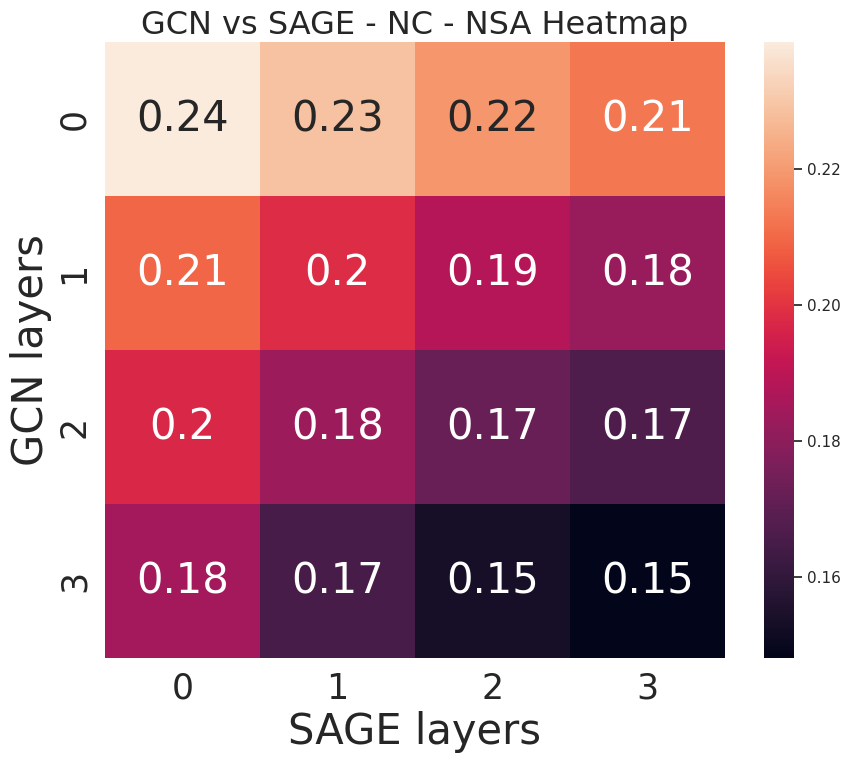

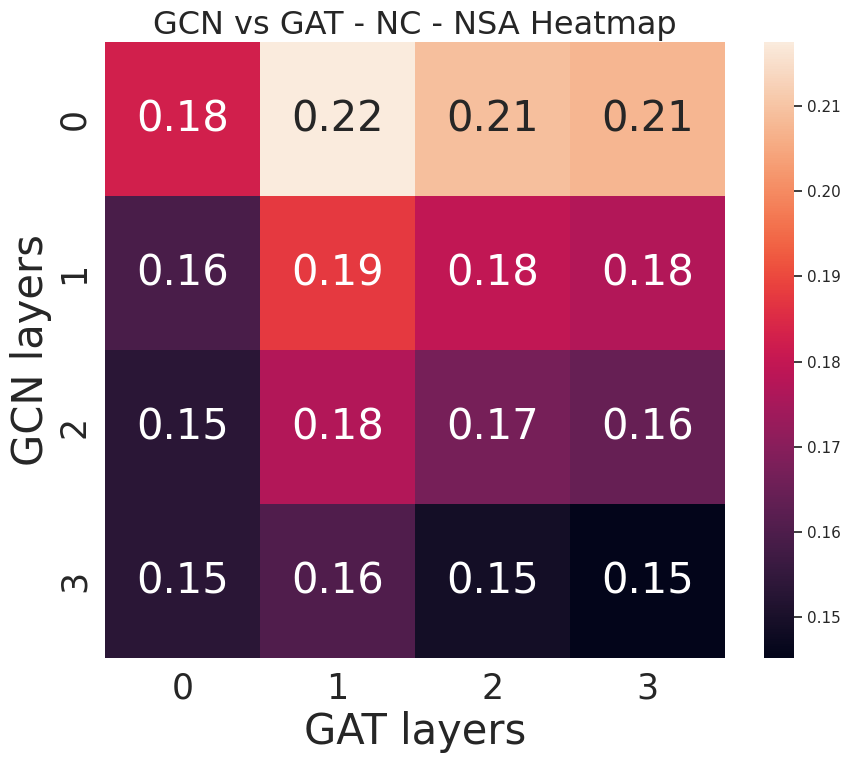

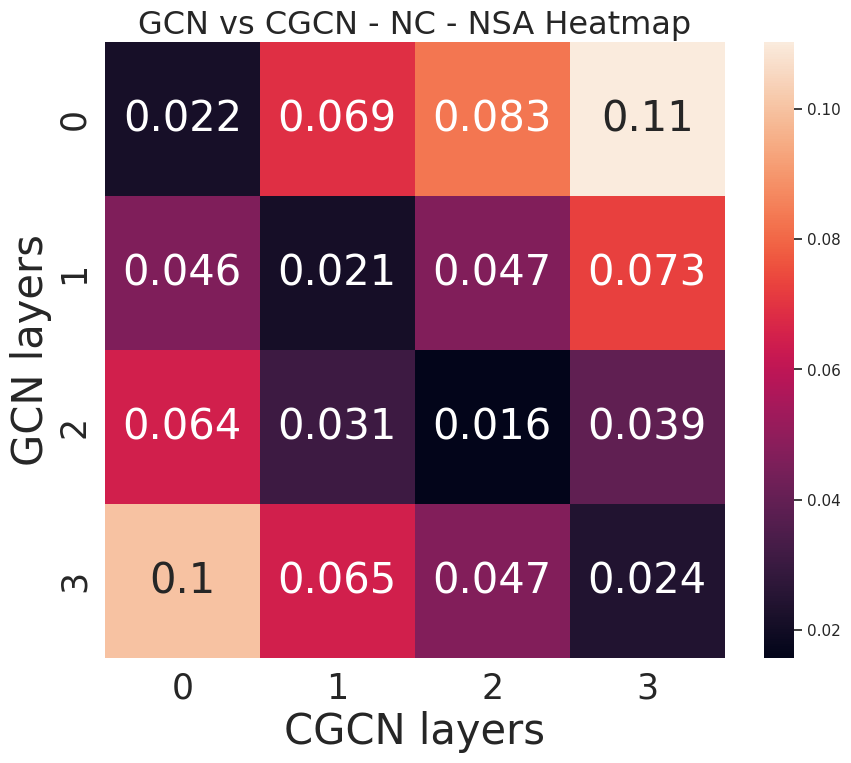

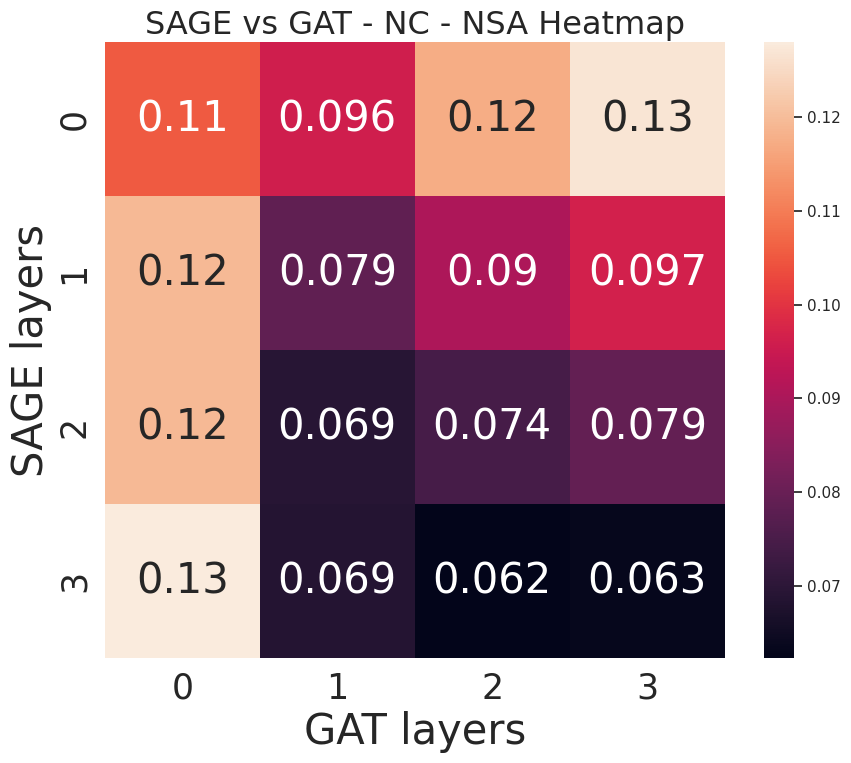

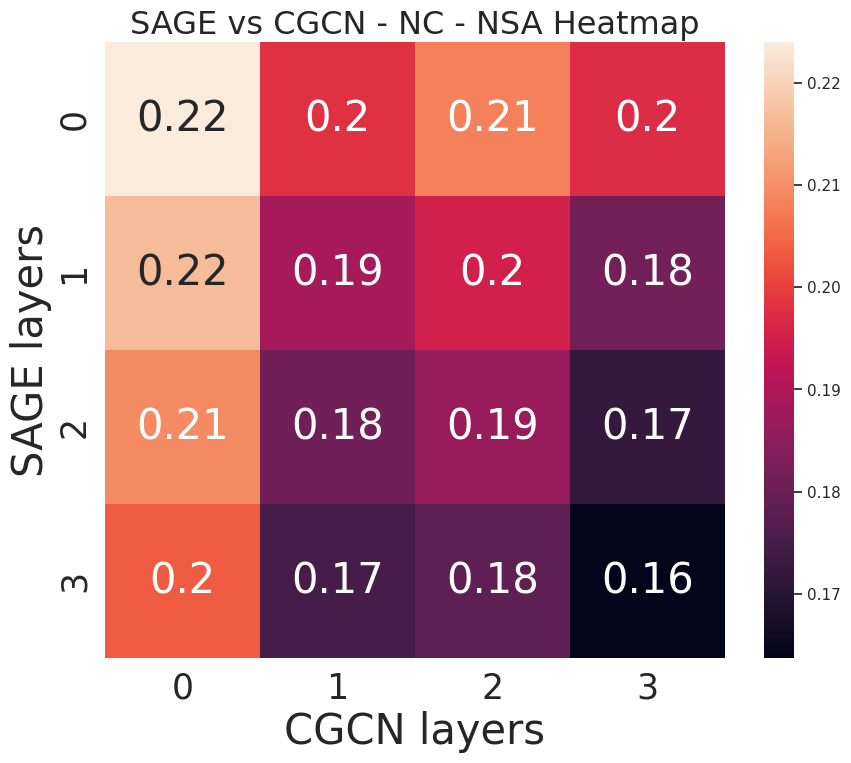

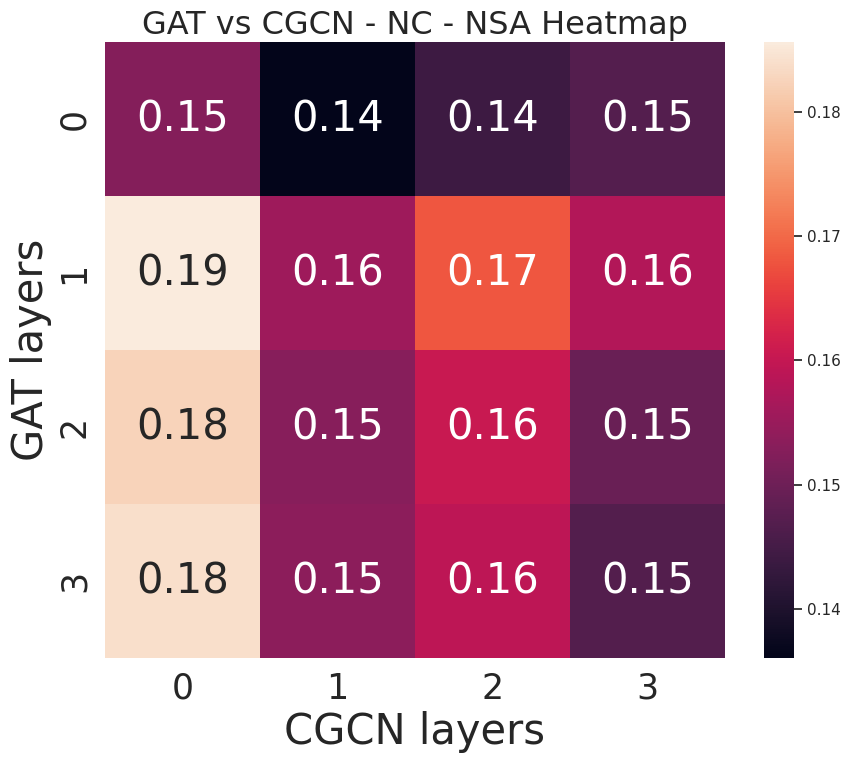

All heatmaps saved successfully.


In [40]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the output directory where you want to save the heatmap images
output_directory = f'heatmaps/{dataset_name}/cross_arch_tests/{task}/'
!mkdir -p $output_directory

# Create the output directory if it doesn't exist
#os.makedirs(output_directory, exist_ok=True)

# Iterate through the nested dictionary
for model_name, metrics in heatmap_holder.items():
    for metric_name, heatmap_data in metrics.items():
        # Create a heatmap plot using seaborn
        sns.set()
        plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
        if metric_name=='CKA':
            heatmap_data = 1 - heatmap_data
            metric_name = "CKA'"
        annot_kwargs = {"fontsize": 30}  # Adjust the fontsize as needed
        
        ax = sns.heatmap(heatmap_data, annot=True, annot_kws=annot_kwargs, cbar=True)  # Modify cmap and formatting as needed
        model1, model2 = model_name.split('_')
        plt.title(f'{model1} vs {model2} - {task} - {metric_name} Heatmap', fontsize=23)
        plt.xlabel(f'{model2} layers', fontsize=30) # X axis is always model 2
        plt.ylabel(f'{model1} layers', fontsize=30) # Y axis is model 1 since the second loop iterates over columns
        # Save the heatmap plot as an image
        plt.xticks(fontsize=25)
        plt.yticks(fontsize=25)
        plt.show()
        # output_filename = f'{model_name}_{metric_name}_heatmap.png'
        # output_path = os.path.join(output_directory, output_filename)
        # plt.savefig(output_path, bbox_inches='tight')
        # plt.close()  # Close the plot to release resources

        # print(f'Saved: {output_path}')

print('All heatmaps saved successfully.')

## Cross Downstream Task Tests

In [24]:
# Iterate over models
heatmap_holder = {}
tasks = ["NC","LP"]
n = len(models)  # Change this to your desired matrix size
# Initialize an empty list to store the indices of the upper triangle

# Loop through the rows and columns of the matrix
for model in models:        
        identifier1 = f'{model}/{tasks[0]}_{run_ids[0]}_'
        identifier2 = f'{model}/{tasks[1]}_{run_ids[0]}_'
    
        fv_path1 = path+identifier1+str(max_epochs[identifier1])
        fv_path2 = path+identifier2+str(max_epochs[identifier2])
        A_data = np.load(fv_path1+".npz")
        B_data = np.load(fv_path2+".npz")
        print(fv_path1)
        print(fv_path2)
        print("Currently running for: ",model)
        heatmap_holder[model]={}
        A = dict(A_data)
        B = dict(B_data)
        l1 = len(A.keys())
        l2 = len(B.keys())
        if l1!=l2:
            break
        conv_layers = list(A.keys())
        nsa_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),min(4000,A[conv_layers[0]].shape[0]), replace=False)
        rtd_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),250, replace=False)
        cka_heatmap = np.empty((l1,l2))
        rtd_heatmap = np.empty((l1,l2))
        nsa_heatmap = np.empty((l1,l2))
        for i,layer1 in enumerate(conv_layers):
          for j,layer2 in enumerate(conv_layers):
            print("Grid ID: ",i,j)
            X = A[layer1]
            Y = B[layer2]
            # print("Calculating CKA")
            # cka_heatmap[i,j]=cka(gram_linear(X),gram_linear(Y))
            print("Calculating NSA")
            nsa_heatmap[i,j]=nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))
            # print("Calculating RTD")
            # rtd_heatmap[i,j]=rtd(X[rtd_sample_indices],Y[rtd_sample_indices])
        # heatmap_holder[model]['CKA']=cka_heatmap
        heatmap_holder[model]['NSA']=nsa_heatmap
        # heatmap_holder[model]['RTD']=rtd_heatmap

model_data/Amazon/GCN/NC_1_199
model_data/Amazon/GCN/LP_1_200
Currently running for:  GCN
Grid ID:  0 0
Calculating NSA
Grid ID:  0 1
Calculating NSA
Grid ID:  0 2
Calculating NSA
Grid ID:  0 3
Calculating NSA
Grid ID:  1 0
Calculating NSA
Grid ID:  1 1
Calculating NSA
Grid ID:  1 2
Calculating NSA
Grid ID:  1 3
Calculating NSA
Grid ID:  2 0
Calculating NSA
Grid ID:  2 1
Calculating NSA
Grid ID:  2 2
Calculating NSA
Grid ID:  2 3
Calculating NSA
Grid ID:  3 0
Calculating NSA
Grid ID:  3 1
Calculating NSA
Grid ID:  3 2
Calculating NSA
Grid ID:  3 3
Calculating NSA
model_data/Amazon/SAGE/NC_1_100
model_data/Amazon/SAGE/LP_1_200
Currently running for:  SAGE
Grid ID:  0 0
Calculating NSA
Grid ID:  0 1
Calculating NSA
Grid ID:  0 2
Calculating NSA
Grid ID:  0 3
Calculating NSA
Grid ID:  1 0
Calculating NSA
Grid ID:  1 1
Calculating NSA
Grid ID:  1 2
Calculating NSA
Grid ID:  1 3
Calculating NSA
Grid ID:  2 0
Calculating NSA
Grid ID:  2 1
Calculating NSA
Grid ID:  2 2
Calculating NSA
Grid ID

In [ ]:
import pickle
save_path = f'cross_task_test_{dataset_name}_heatmap_holder.pkl'
with open(save_path, 'wb') as file:
    pickle.dump(heatmap_holder, file)

In [ ]:
load_path = f'cross_task_test_{dataset_name}_heatmap_holder.pkl'
with open(load_path, 'rb') as file:
    heatmap_holder = pickle.load(file)

#heatmap_holder

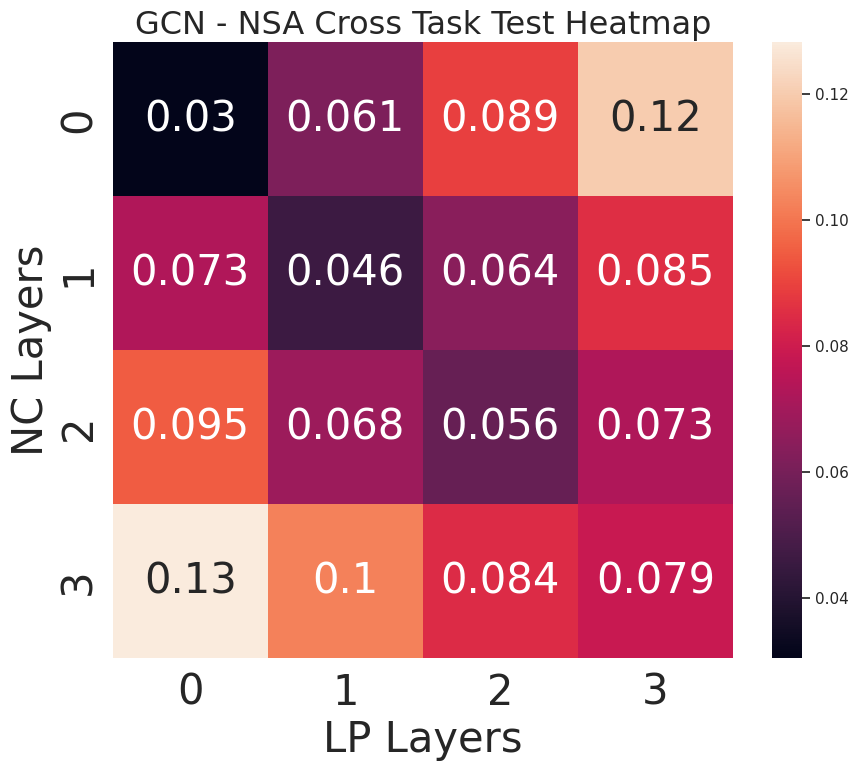

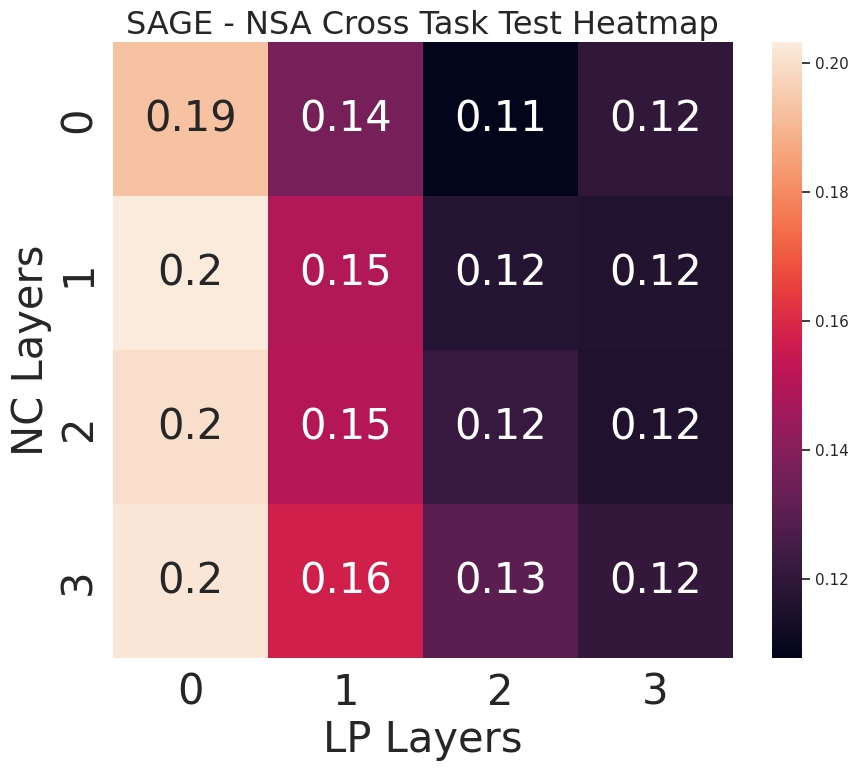

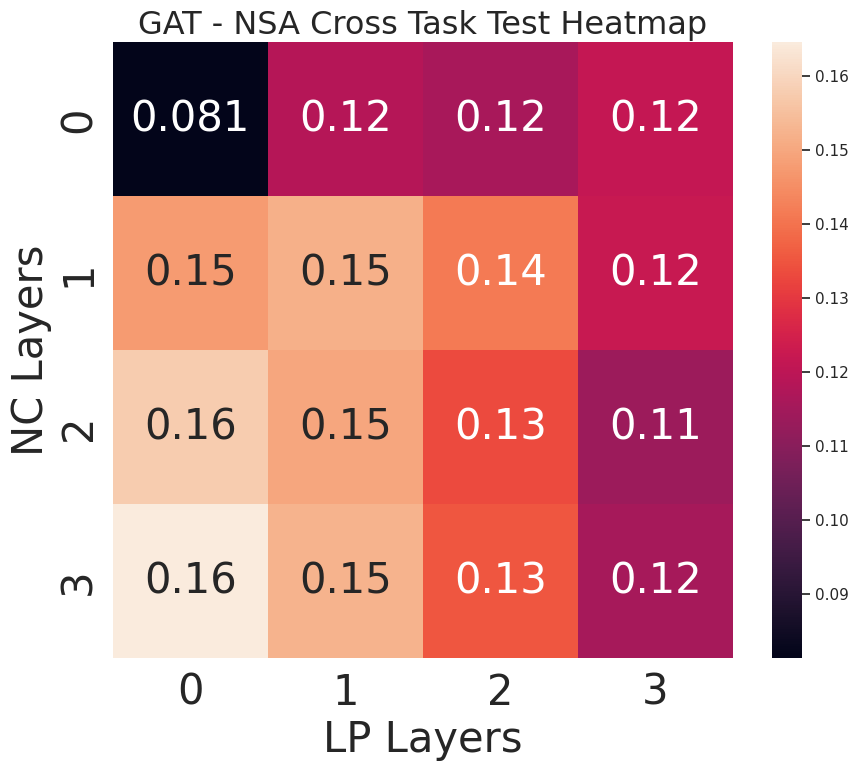

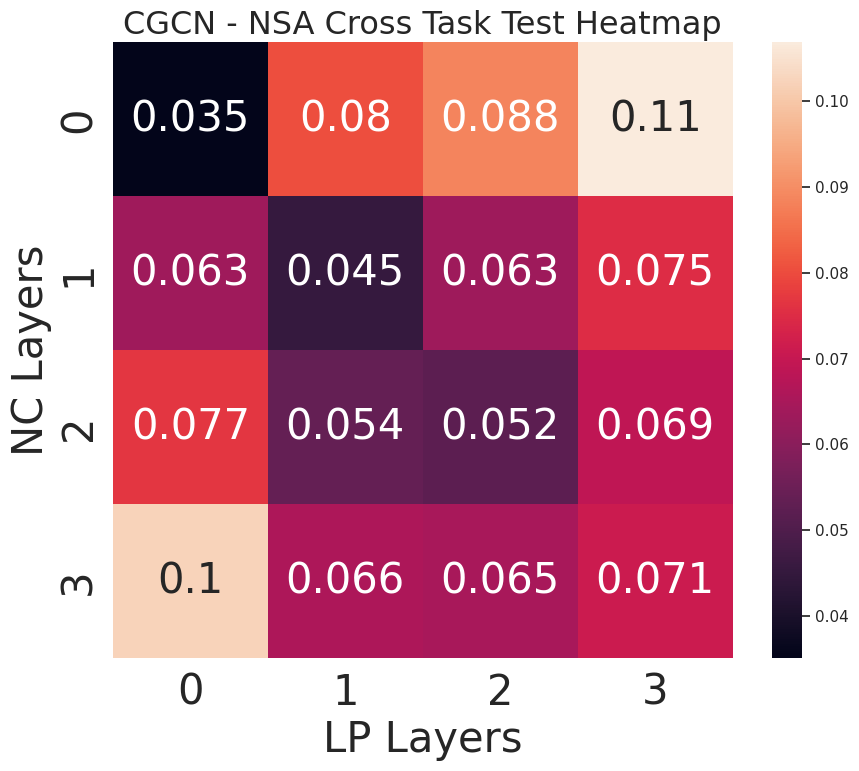

All heatmaps saved successfully.


In [25]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

task_list = ["NC","LP"]
# Define the output directory where you want to save the heatmap images
output_directory = f'heatmaps/{dataset_name}/cross_task_tests/'
!mkdir -p $output_directory

# Create the output directory if it doesn't exist
#os.makedirs(output_directory, exist_ok=True)

# Iterate through the nested dictionary
for model_name, metrics in heatmap_holder.items():
    for metric_name, heatmap_data in metrics.items():
        # Create a heatmap plot using seaborn
        sns.set()
        plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
        if metric_name=='CKA':
            heatmap_data = 1 - heatmap_data
            metric_name = "CKA'"
        annot_kwargs = {"fontsize": 30}  # Adjust the fontsize as needed
        
        ax = sns.heatmap(heatmap_data, annot=True, annot_kws=annot_kwargs, cbar=True)  # Modify cmap and formatting as needed
        plt.title(f'{model_name} - {metric_name} Cross Task Test Heatmap', fontsize=23)
        plt.xlabel(f'{task_list[1]} Layers', fontsize=30) # X axis is always model 2
        plt.ylabel(f'{task_list[0]} Layers', fontsize=30) # Y axis is model 1 since the second loop iterates over columns
        # Save the heatmap plot as an image
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.show()
        # output_filename = f'{model_name}_{metric_name}_heatmap.png'
        # output_path = os.path.join(output_directory, output_filename)
        # plt.savefig(output_path, bbox_inches='tight')
        # plt.close()  # Close the plot to release resources

        # print(f'Saved: {output_path}')

print('All heatmaps saved successfully.')

## Convergence Tests

In [26]:
# Iterate over models
heatmap_holder = {}
n = len(models)  # Change this to your desired matrix size
# Initialize an empty list to store the indices of the upper triangle

# Loop through the rows and columns of the matrix
for model in models:        
    identifier1 = f'{model}/{task}_{run_ids[0]}_'
    identifier2 = f'{model}/{task}_{run_ids[0]}_'
    heatmap=np.empty((4,max_epochs[identifier1]//5))
    print(heatmap.shape)
    heatmap_holder[model]={}
    fv_path1 = path+identifier1+str(max_epochs[identifier1])
    A_data = np.load(fv_path1+".npz")
    print(fv_path1)
    A = dict(A_data)
    conv_layers = list(A.keys())
    print("Currently running for: ",model)
    nsa_sample_indices = np.random.choice(range(A[conv_layers[0]].shape[0]),4000, replace=False)
    for i,epoch in enumerate(range(5,max_epochs[identifier1]+1,5)):
        fv_path2 = path+identifier2+str(epoch)
        print(fv_path2, epoch)
        
        B_data = np.load(fv_path2+".npz")
        B = dict(B_data)
        l1 = len(A.keys())
        l2 = len(B.keys())
        if l1!=l2:
            break
        conv_layers = list(A.keys())
        for j,layer in enumerate(conv_layers):
            print("Grid ID: ",j,i)
            X = A[layer]
            Y = B[layer]
            print("Calculating NSA")
            heatmap[j,i]=nsa_criterion(torch.tensor(X[nsa_sample_indices],dtype=float), torch.tensor(Y[nsa_sample_indices],dtype=float))
        heatmap_holder[model]['NSA']=heatmap

(4, 39)
model_data/Amazon/GCN/NC_1_199
Currently running for:  GCN
model_data/Amazon/GCN/NC_1_5 5
Grid ID:  0 0
Calculating NSA
Grid ID:  1 0
Calculating NSA
Grid ID:  2 0
Calculating NSA
Grid ID:  3 0
Calculating NSA
model_data/Amazon/GCN/NC_1_10 10
Grid ID:  0 1
Calculating NSA
Grid ID:  1 1
Calculating NSA
Grid ID:  2 1
Calculating NSA
Grid ID:  3 1
Calculating NSA
model_data/Amazon/GCN/NC_1_15 15
Grid ID:  0 2
Calculating NSA
Grid ID:  1 2
Calculating NSA
Grid ID:  2 2
Calculating NSA
Grid ID:  3 2
Calculating NSA
model_data/Amazon/GCN/NC_1_20 20
Grid ID:  0 3
Calculating NSA
Grid ID:  1 3
Calculating NSA
Grid ID:  2 3
Calculating NSA
Grid ID:  3 3
Calculating NSA
model_data/Amazon/GCN/NC_1_25 25
Grid ID:  0 4
Calculating NSA
Grid ID:  1 4
Calculating NSA
Grid ID:  2 4
Calculating NSA
Grid ID:  3 4
Calculating NSA
model_data/Amazon/GCN/NC_1_30 30
Grid ID:  0 5
Calculating NSA
Grid ID:  1 5
Calculating NSA
Grid ID:  2 5
Calculating NSA
Grid ID:  3 5
Calculating NSA
model_data/Amazon

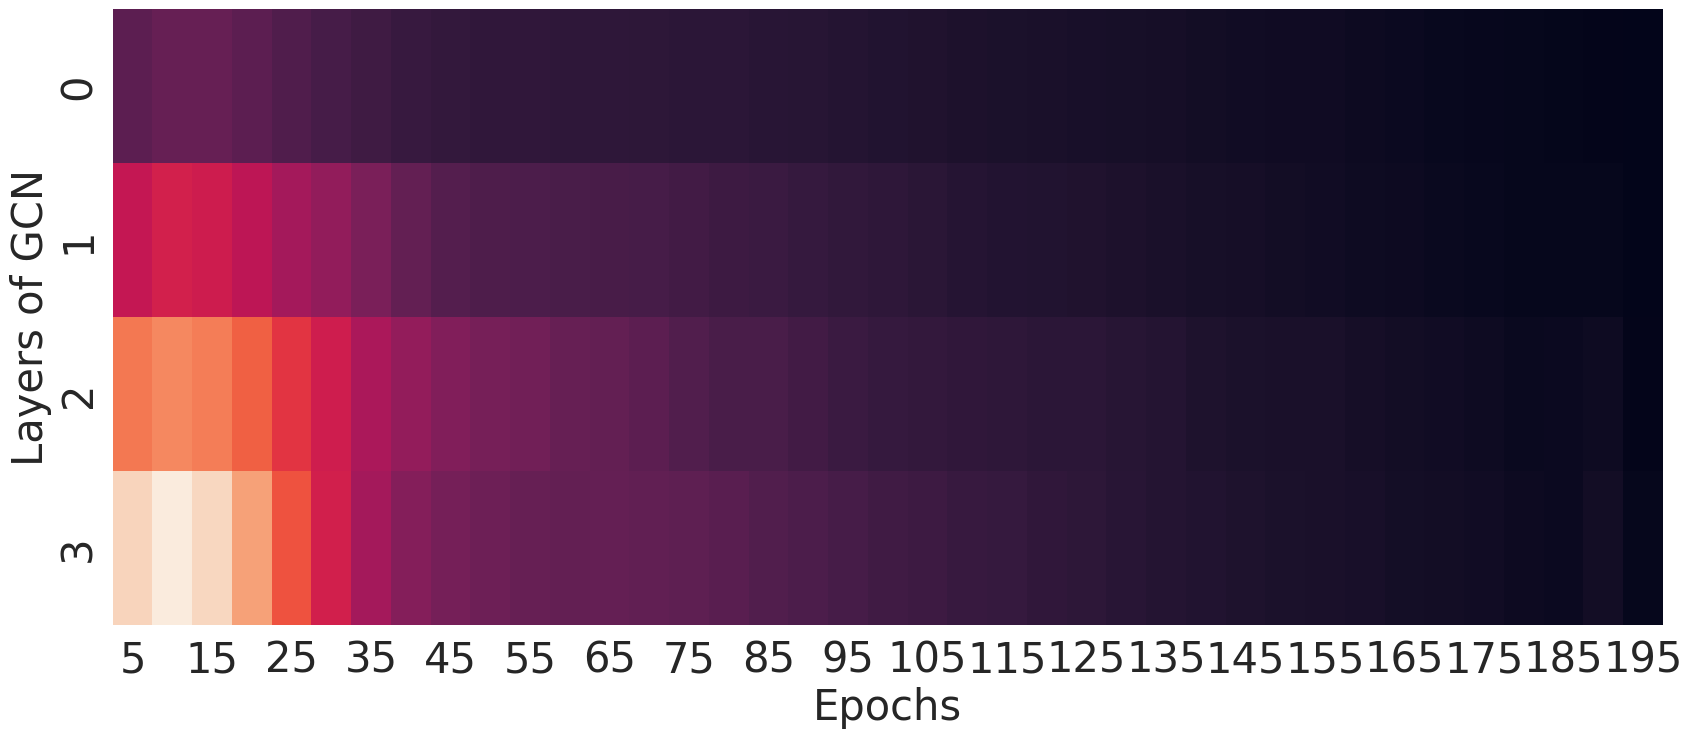

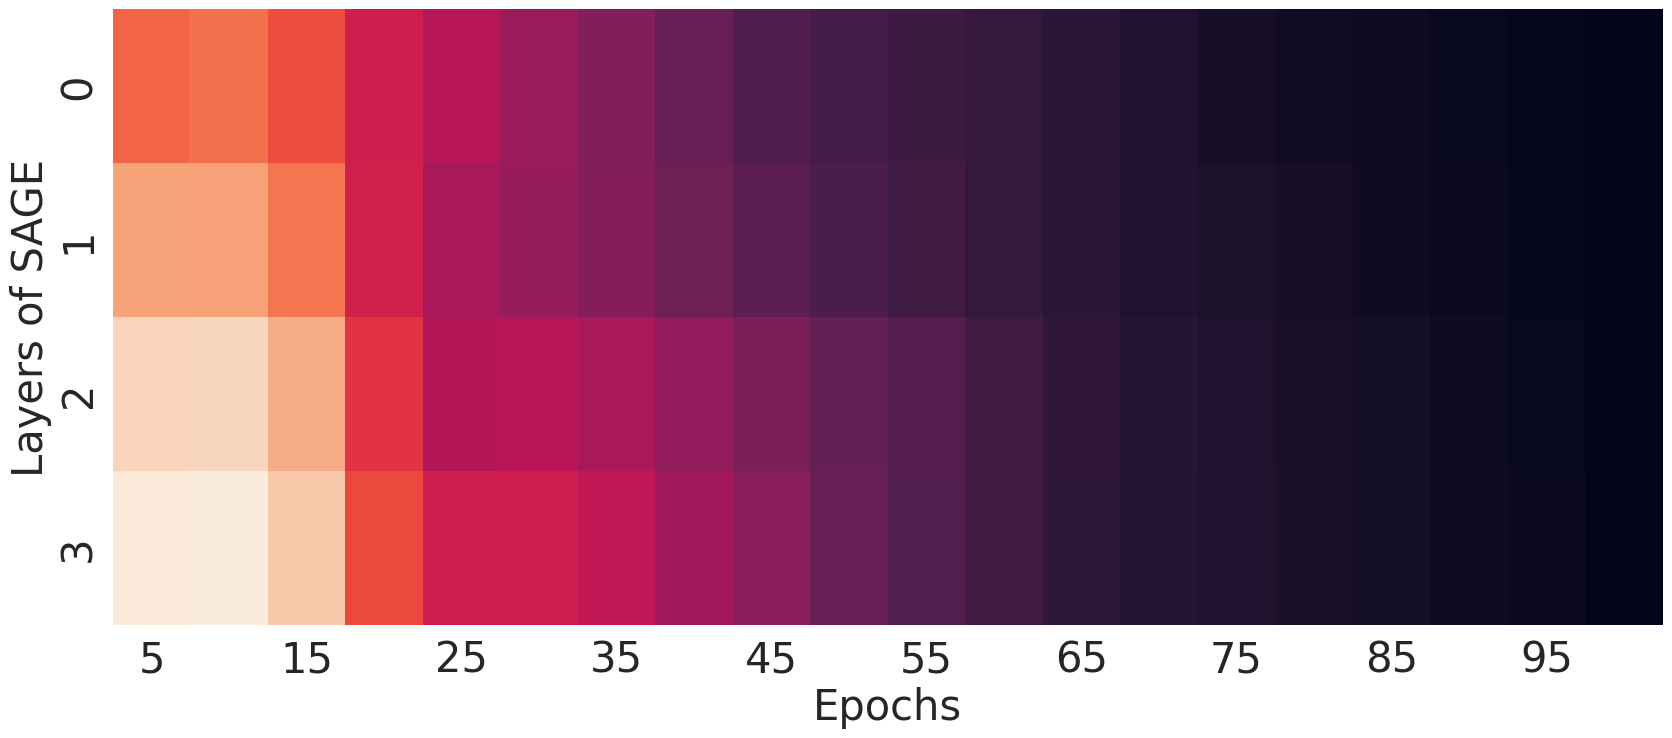

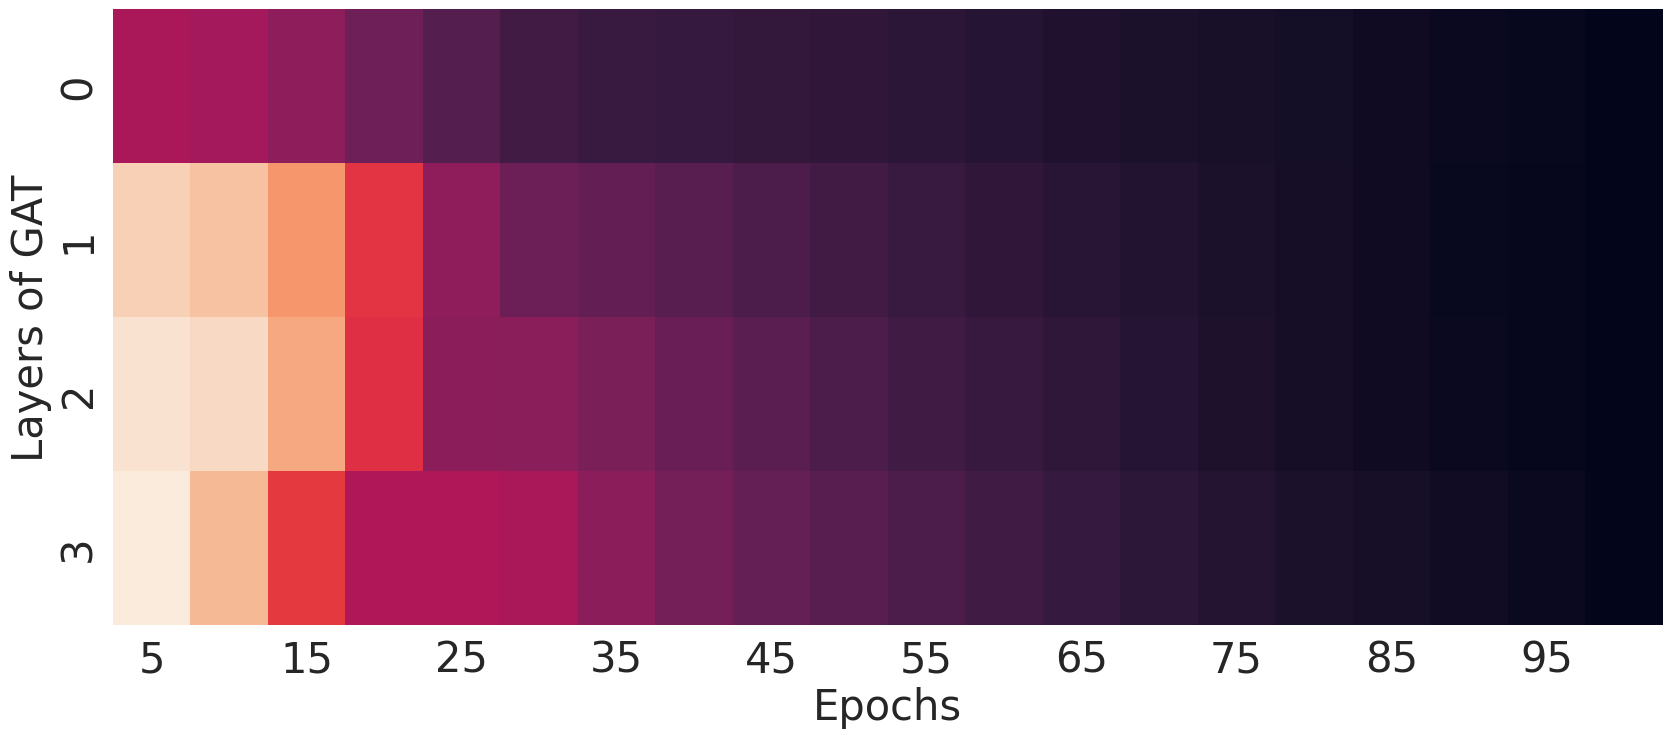

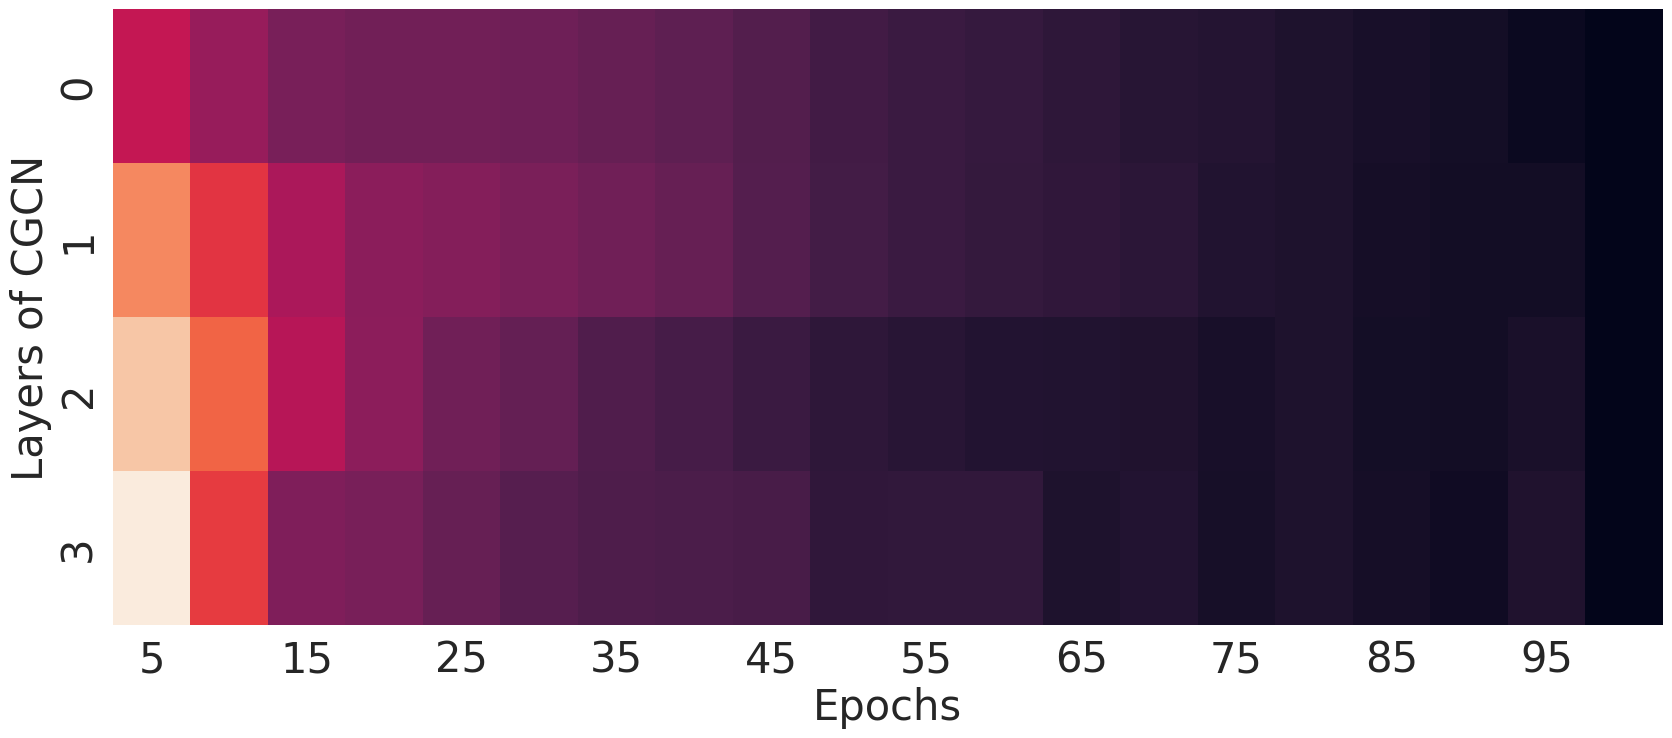

All heatmaps saved successfully.


In [27]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Define the output directory where you want to save the heatmap images
output_directory = f'heatmaps/{dataset_name}/convergence_tests/{task}/'
!mkdir -p $output_directory

# Create the output directory if it doesn't exist
#os.makedirs(output_directory, exist_ok=True)


# Iterate through the nested dictionary
for model_name, metrics in heatmap_holder.items():
    for metric_name, heatmap_data in metrics.items():
        # Create a heatmap plot using seaborn
        sns.set()
        plt.figure(figsize=(20, 8))  # Adjust the figure size as needed
        if metric_name=='CKA':
            heatmap_data = 1 - heatmap_data
            metric_name = "CKA'"
        #formatted_heatmap_data = np.vectorize(lambda x: f'{x:.1e}')(heatmap_data)
        annot_kwargs = {"fontsize": 14}  # Adjust the fontsize as needed
        if task=='NC':
            ax = sns.heatmap(heatmap_data, annot=False, annot_kws=annot_kwargs, cbar=False)  # Modify cmap and formatting as needed
        else:
            ax = sns.heatmap(heatmap_data, annot_kws=annot_kwargs, cbar=False)  # Modify cmap and formatting as needed
        #plt.title(f'{model_name} - {metric_name} - {task} Convergence Test Heatmap', fontsize=23)
        plt.xlabel(f'Epochs', fontsize=30) # X axis is always model 2
        plt.ylabel(f'Layers of {model_name}', fontsize=30) # Y axis is model 1 since the second loop iterates over columns
        xticks = plt.xticks()[0]
        identifier = f'{model_name}/{task}_{1}_'
        
        plt.xticks(xticks[::2], np.arange(5,max_epochs[identifier]+1,10))
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        # Save the heatmap plot as an image
        plt.show()
        # output_filename = f'{model_name}_{metric_name}_heatmap.png'
        # output_path = os.path.join(output_directory, output_filename)
        # plt.savefig(output_path, bbox_inches='tight')
        # plt.close()  # Close the plot to release resources

        # print(f'Saved: {output_path}')

print('All heatmaps saved successfully.')